Taken from https://www.kaggle.com/wcukierski/example-metric-implementation/code

All markdown cells are my personal notes.

First of all: this uses scikit-image instead of opencv to read the images. The same function can be implemented with the following lines of code. The Raul Kernel is more complicated than that, uselessly IMHO. View block 2, line 11

`img1 = cv2.imread('img1.jpg')
img2 = cv2.imread('img2.jpg')`

`both = np.hstack((img1,img2))`

Second: he does this on a radomly selected image. Note that the code is much more straightforward that the Raul's one, we might as well implement in ours

In [1]:
%matplotlib inline
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
import skimage.segmentation

# Load a single image and its associated masks
id = '0d2bf916cc8de90d02f4cd4c23ea79b227dbc45d845b4124ffea380c92d34c8c'
file = "input/stage1_train/{}/images/{}.png".format(id,id)
masks = "input/stage1_train/{}/masks/*.png".format(id)
image = skimage.io.imread(file)
masks = skimage.io.imread_collection(masks).concatenate()
height, width, _ = image.shape
num_masks = masks.shape[0]

Here it defines the concatenated masks array as a ground truth and makes a fake predicted masks. I do not know how to extrapolate the predicted masks from the Raul's Kernel, but I haven't really tried since we'd better do it on Adam's one

In [2]:
# Make a ground truth label image (pixel value is index of object label)
labels = np.zeros((height, width), np.uint16)
for index in range(0, num_masks):
    labels[masks[index] > 0] = index + 1
    
# Simulate an imperfect submission
offset = 2 # offset pixels
y_pred = labels[offset:, offset:]
y_pred = np.pad(y_pred, ((0, offset), (0, offset)), mode="constant")
y_pred[y_pred == 20] = 0 # Remove one object
y_pred, _, _ = skimage.segmentation.relabel_sequential(y_pred) # Relabel objects

Sanity check

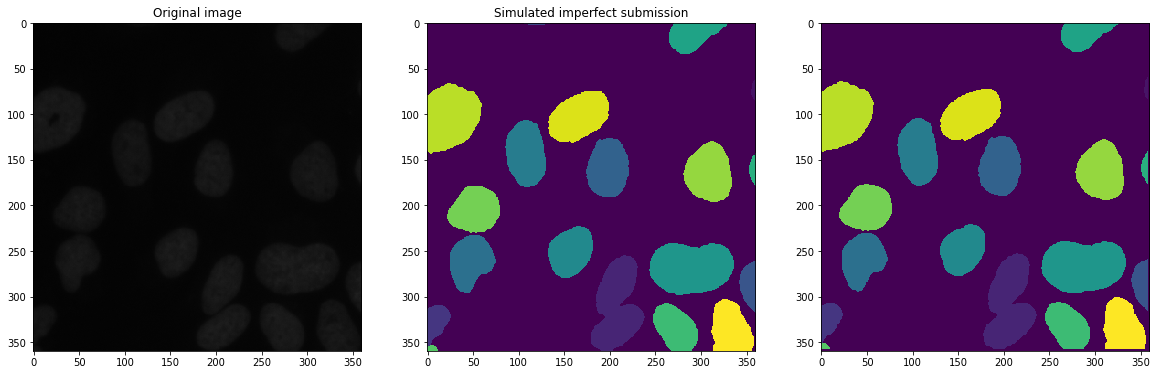

In [3]:
plt.figure(figsize=(20, 10))

# Show label image
ax = plt.subplot(131)
ax.set_title("Original image")
imgplot = plt.imshow(image)
ax2 = plt.subplot(132)
ax2.set_title("Ground truth masks")
imgplot2 = plt.imshow(labels)

# Show simulated predictions
ax3 = plt.subplot(133)
ax3.set_title("Simulated imperfect submission")
imgplot3 = plt.imshow(y_pred)

plt.show()

Ok. Here it takes the labels generated in the previous step and counts them. Does the same for the fake mask and prints them out. Of course, right now they are the same number, but in our model can vary. 

In [4]:
# Compute number of objects
true_objects = len(np.unique(labels))
pred_objects = len(np.unique(y_pred))
print("Number of true objects:", true_objects)
print("Number of predicted objects:", pred_objects)

Number of true objects: 20
Number of predicted objects: 20


This is the interesting part. First of all he uses the .flatten attribute which flattens the array (to a single vector?) of both the ground truth (labels) and the fake mask (y_pred), and then intersects the two vectors. 

Then compute the areas of each label using the .histogram attribute and summing all values. 

I think he subtracts the intersection from union because otherwise the areas in the intersection will just sum up twice. There might be a better way to do it. Same for the background exclusion. 

In [5]:
# Compute intersection between all objects
intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

# Compute areas (needed for finding the union between all objects)
area_true = np.histogram(labels, bins = true_objects)[0]
area_pred = np.histogram(y_pred, bins = pred_objects)[0]
area_true = np.expand_dims(area_true, -1)
area_pred = np.expand_dims(area_pred, 0)

# Compute union
union = area_true + area_pred - intersection

# Exclude background from the analysis
intersection = intersection[1:,1:]
union = union[1:,1:]
union[union == 0] = 1e-9

# Compute the intersection over union
iou = intersection / union

Here is the interesting part: the definition of TP, FP, FN. The precision metric (which is actually an accuracy metric) just using the formula reported in the Kaggle page. However, he defines matches the IoU ratios bigger than the threshold. For how the IoU is calculated, this means that each nucleus in the mask will have an inner area (intersection) and missed outside areas (which corresponds to area_true + area_pred - 2intersection). This means that either predicting a bigger area than the true one or a smaller area than the true one will count with the same weight.

This calculation is repeated per each threshold. Basically this means that there will be a some nuclei identified with a certain threshold, some other nuclei which will fall in another threshold of detection and so on. Clearly we increase the number of nuclei in the higher threshold than in the lower ones. Remember that, from how it is written here, we are not counting single objects but rather cumulative areas for each threshold.

Then he just averages all the results, as reported i the Kaggle page, which is the most logical way to proceed. 

In [6]:
# Precision helper function
def precision_at(threshold, iou):
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    return tp, fp, fn

# Loop over IoU thresholds
prec = []
print("Thresh\tTP\tFP\tFN\tPrec.")
for t in np.arange(0.5, 1.0, 0.05):
    tp, fp, fn = precision_at(t, iou)
    p = tp / (tp + fp + fn)
    print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
    prec.append(p)
print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

Thresh	TP	FP	FN	Prec.
0.500	15	4	4	0.652
0.550	15	4	4	0.652
0.600	15	4	4	0.652
0.650	15	4	4	0.652
0.700	15	4	4	0.652
0.750	14	5	5	0.583
0.800	13	6	6	0.520
0.850	11	8	8	0.407
0.900	1	18	18	0.027
0.950	0	19	19	0.000
AP	-	-	-	0.480


Finally: AP is the score for ONE SINGLE (fake) predicted mask. We need to average then ALL the scores for all predicted masks.

IMPORTANT NOTE! THIS SCORE DOES NOT CONSIDER SPLITTING NUCLEI!! If you have two nuclei attached and you split your predicted masks into two you might increase your score depending on WHERE this separation goes. For example: if the model predicts a convex shape on the left and a concave shape on the right, whereas the true masks have a concave on the left and a convex on the right, you will double the number of FP and FN pixels. To me it is unclear on how to account for that. 

OTHER NOTE: the whole score metric assumes you have predicted masks and true masks. Meaning that our model has to predict masks that hasn't observed, I guess. Therefore we need a validation set!!!